<font size=8> DynapSE2 TimeConstant Extraction


In [1]:
#normal python import
from pickle import TRUE
import time
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd() + '/..')

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression

#my imports
from adaptation import pc_single
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from adaptation_lib.tc_extraction import *

# Determine the user's home directory
home_directory = os.path.expanduser("~")
# Path to the Documents directory
documents_path = os.path.join(home_directory, "Documents")
# Path to the dynapse-se2-data directory within Documents
save_directory_path = os.path.join(documents_path, "dynapse-se2-data")
# Path to the data
data_type_path = os.path.join(save_directory_path, "SFA")

<font size=5> graphing

In [2]:
file_name='/SFA_on.npy'
def SFA_DATA(file_name,bin_size=.020):
    output_events=np.load(data_type_path+file_name,allow_pickle=True)
    output_events=np.asanyarray(output_events)
    times=output_events[1]-output_events[1][0]
    spike_id=output_events[0]
    neuron_n=255
    virual_n=10
    duration = round(times[-1],1)

    pc_id, pc_times = get_id_times(virual_n, neuron_n, spike_id, times)

    if virual_n > 0:
        input_id = spike_id[spike_id <= virual_n]
        input_time = times[spike_id <= virual_n]

    [isi_list,isi_times]=extract_isi(pc_id,pc_times)
    # PSTH plot
    spike_times = spike_time_arrays(output_events, virual_n, neuron_n)[1]
    psth, bins = psth_calc(spike_times, bin_size, duration)
    # Flatten the ISI lists
    all_isis = np.concatenate(isi_list)
    return input_id,input_time,pc_id,pc_times,all_isis,isi_list,isi_times,psth,bins



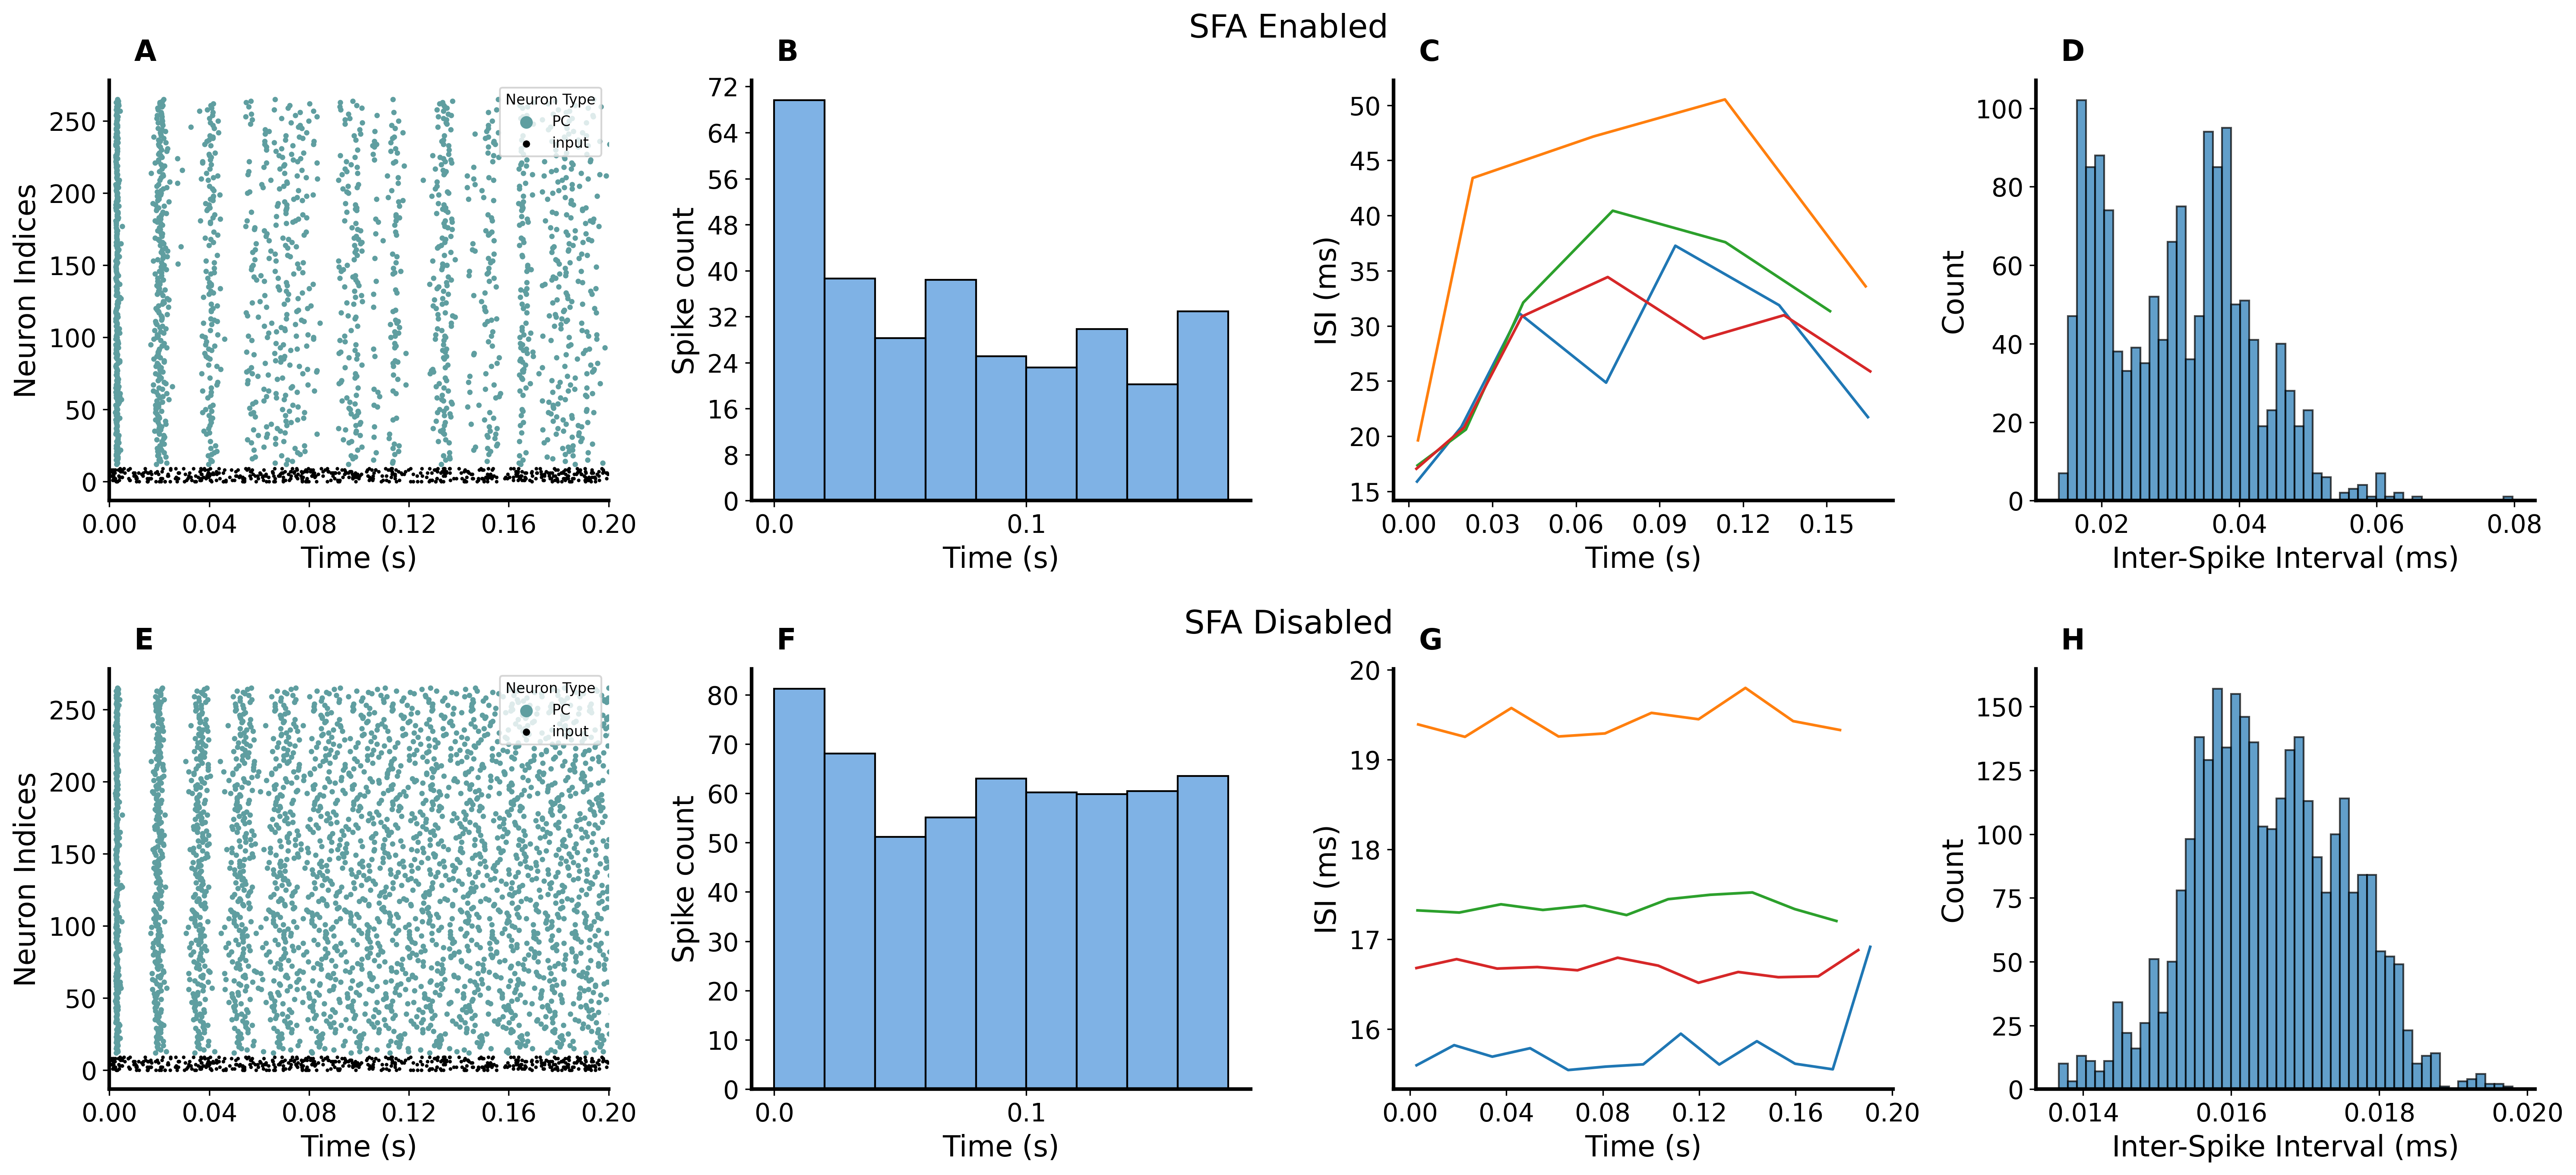

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Control variables for font sizes and styles
FONT_SIZE = 16
FONT_SIZE_TITLE = 18
TICK_SIZE = 14  # New variable for tick size
AXES_LINEWIDTH = 2  # New variable for axes line thickness
file_1 = '/SFA_on.npy'
file_2 = '/SFA_off.npy'

# Load data using your custom SFA_DATA function
# Assuming SFA_DATA is a function you have defined elsewhere that returns the necessary data
input_ids_1, input_times_1, ids_1, times_1, all_isis_1, isi_list_1, isi_times_1, psth_1, bins_1 = SFA_DATA(file_1, bin_size=.020)
input_ids_2, input_times_2, ids_2, times_2, all_isis_2, isi_list_2, isi_times_2, psth_2, bins_2 = SFA_DATA(file_2, bin_size=.020)
bin_size = .020

duration_1 = round(times_1[-1], 1)
duration_2 = round(times_2[-1], 1)

# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10),dpi=300)  # Adjusted to 2x8 subplots
axs = axs.ravel()  # Flatten the 2D array of axes for easy iteration
# Define letters and their positions
letter_position = (0.05, 1.1)
# The positions are examples, you may need to adjust them
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
positions = [(0.05, 0.9), (0.05, 0.9), (0.05, 0.9), (0.05, 0.9),
             (0.05, 0.9), (0.05, 0.9), (0.05, 0.9), (0.05, 0.9)]  # (x, y) in axes fraction

# Modify the create_plots function to include letters
def create_plots(axs, data, duration, file_index, letters, positions):
    input_ids, input_times, ids, times, all_isis, isi_list, isi_times, psth, bins = data

    # Raster plot
    axs[0 + 4 * file_index].scatter(times, ids, c='cadetblue', s=4, label='PC')
    axs[0 + 4 * file_index].scatter(input_times, input_ids, c='k', s=1, label='input')
    axs[0 + 4 * file_index].set_ylabel('Neuron Indices', fontsize=FONT_SIZE)
    axs[0 + 4 * file_index].set_xlabel('Time (s)', fontsize=FONT_SIZE)
    axs[0 + 4 * file_index].legend(loc="upper right", title='Neuron Type', numpoints=1, fontsize=8, markerscale=3, title_fontsize=8)
    axs[0 + 4 * file_index].set_xlim(0, duration)
    axs[0 + 4 * file_index].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

    # PSTH plot
    bar_color = (0, 0.4, 0.8, 0.5)
    axs[1 + 4 * file_index].bar(bins[:-1], psth, width=bin_size, align='edge', color=bar_color, edgecolor='black', linewidth=1)
    axs[1 + 4 * file_index].set_xlabel('Time (s)', fontsize=FONT_SIZE)
    axs[1 + 4 * file_index].set_ylabel('Spike count', fontsize=FONT_SIZE)
    axs[1 + 4 * file_index].set_xticks(np.arange(0, duration, 0.1))
    axs[1 + 4 * file_index].xaxis.set_major_locator(ticker.MultipleLocator(.1))
    axs[1 + 4 * file_index].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # ISI times plot
    for i in range(len(isi_list) - 250):
        axs[2 + 4 * file_index].plot(isi_times[i], np.array(isi_list[i]) * 1000, label='neuron id: ' + str(i))
    axs[2 + 4 * file_index].set_xlabel('Time (s)', fontsize=FONT_SIZE)
    axs[2 + 4 * file_index].set_ylabel('ISI (ms)', fontsize=FONT_SIZE)
    axs[2 + 4 * file_index].xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

    # ISI histogram
    axs[3 + 4 * file_index].hist(all_isis, bins=50, edgecolor='black', alpha=0.7)
    axs[3 + 4 * file_index].set_xlabel('Inter-Spike Interval (ms)', fontsize=FONT_SIZE)
    axs[3 + 4 * file_index].set_ylabel('Count', fontsize=FONT_SIZE)

    # Remove top and right spines for all subplots
    for ax in axs[4 * file_index:4 * (file_index + 1)]:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)


    # Add letters to each subplot
    for i in range(4):
        ax = axs[i + 4 * file_index]
        letter = letters[i + 4 * file_index]
        ax.text(letter_position[0], letter_position[1], letter, transform=ax.transAxes, fontsize=FONT_SIZE,
                fontweight='bold', va='top', ha='left')


# Create plots for the first file
create_plots(axs, (input_ids_1, input_times_1, ids_1, times_1, all_isis_1, isi_list_1, isi_times_1, psth_1, bins_1), duration_1, 0, letters, positions)
create_plots(axs, (input_ids_2, input_times_2, ids_2, times_2, all_isis_2, isi_list_2, isi_times_2, psth_2, bins_2), duration_2, 1, letters, positions)

# Set title for the bottom plots (second row)

# Manually set titles for the top and bottom rows
fig.text(0.5, 0.92, 'SFA Enabled', ha='center', va='center', fontsize=FONT_SIZE_TITLE)
fig.text(0.5, 0.46, 'SFA Disabled', ha='center', va='center', fontsize=FONT_SIZE_TITLE)

# Apply the tick size and axes line thickness to all subplots
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(AXES_LINEWIDTH)



# Adjust the layout to make space for the titles
plt.tight_layout(rect=[0, 0.03, 1, 0.9])  # Adjust the top value as needed

# Adjust the spacing between the subplots and the edge of the figure
plt.subplots_adjust(top=0.88, hspace=0.4)  # Adjust hspace for space between rows
plt.show()

In [4]:
def plot_raster_and_psth(output_events, virual_n, neuron_n,duration=2,bin_size=0.050):
    """
    Plots a raster plot and a PSTH based on given input data and parameters.
    
    Parameters:
    - data_path: path to the SFA_Control.npy data
    - virual_n, neuron_n: parameters for data extraction
    - get_id_times: function to extract id times
    - extract_isi: function to extract isi list and times
    - spike_time_arrays: function to extract spike times
    - psth_calc: function to calculate psth
    
    Returns:
    - fig: matplotlib figure object
    """
    
    FONT_SIZE = 14
    duration = 2
    bin_size = 0.020
    plt.style.use('seaborn-white')

    # Load and preprocess data
    output_events = np.asanyarray(output_events)
    times = output_events[1] - output_events[1][0]
    spike_id = output_events[0]

    # Extract pc times and ids
    pc_id, pc_times = get_id_times(virual_n, neuron_n, spike_id, times)

    # Handle input data
    if virual_n > 0:
        input_id = spike_id[spike_id <= virual_n]
        input_time = times[spike_id <= virual_n]

    # ISI and PSTH extraction
    isi_list, isi_times = extract_isi(pc_id, pc_times)
    spike_times = spike_time_arrays(output_events, virual_n, neuron_n)[1]
    psth, bins = psth_calc(spike_times, bin_size, duration)

    # Create figure and axes
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Raster plot for ax1
    ax1 = axs[0]
    ax1.scatter(pc_times, pc_id, c='cadetblue', s=4, label='PC')
    ax1.scatter(input_time, input_id, c='k', s=1, label='input')
    ax1.set_xlim(0, duration)
    ax1.set_ylabel('Neuron Indicies', fontsize=FONT_SIZE)
    ax1.set_title('Control Trial', fontsize=FONT_SIZE)
    ax1.legend(loc="upper right", title='Neuron Type', numpoints=1, fontsize=8, markerscale=3, title_fontsize=8, frameon=True)

    # PSTH plot for ax2
    ax2 = axs[1]
    bar_color = (0, 0.4, 0.8, 0.5)
    ax2.bar(bins[:-1], psth, width=bin_size, align='edge', color=bar_color, edgecolor='black', linewidth=1)
    ax2.set_xlabel('Time (s)', fontsize=FONT_SIZE)
    ax2.set_ylabel('Spike count', fontsize=FONT_SIZE)
    ax2.set_xticks(np.arange(0, duration, 0.1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(.1))
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax2.tick_params(axis='both', which='major', labelsize=FONT_SIZE)

    # Remove top and right spines for all subplots
    for ax in axs:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    
    return fig


/tmp/ipykernel_61599/4036690063.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


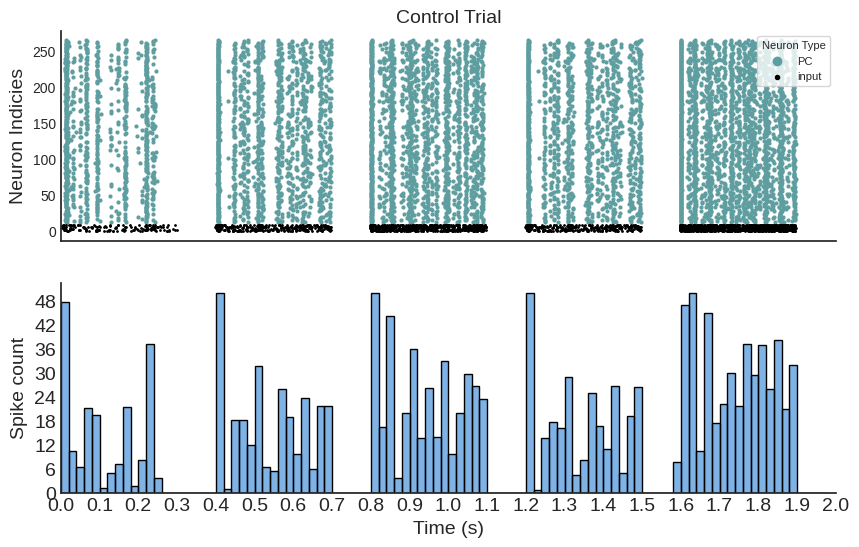

In [5]:
pattern_data_1=np.load(data_type_path+'/SFA_Pattern_ON.npy',allow_pickle=True)
virtual_n=10
neuron_n=255    
fig=plot_raster_and_psth(pattern_data_1, virtual_n, neuron_n)

/tmp/ipykernel_61599/4036690063.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


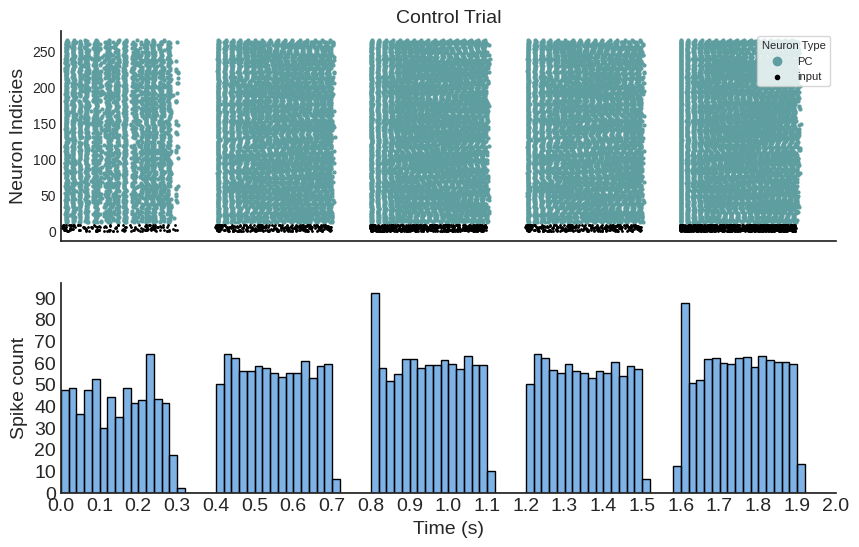

In [6]:
pattern_data_2=np.load(data_type_path+'/SFA_Pattern_OFF.npy',allow_pickle=True)
virtual_n=10
neuron_n=255    
fig=plot_raster_and_psth(pattern_data_2, virtual_n, neuron_n)

In [26]:
def raster_and_psth(output_events,duration,bin_size,virtual_n,neuron_n):  # Load and preprocess data
    output_events = np.asarray(output_events)
    times = output_events[1] - output_events[1][0]
    spike_id = output_events[0]

    # Extract pc times and ids
    pc_id, pc_times = get_id_times(virtual_n, neuron_n, spike_id, times)

    # Handle input data
    if virtual_n > 0:
        input_id = spike_id[spike_id <= virtual_n]
        input_time = times[spike_id <= virtual_n]

    # ISI and PSTH extraction
    spike_times = spike_time_arrays(output_events, virtual_n, neuron_n)[1]
    psth, bins = psth_calc(spike_times, bin_size, duration)
    
    return pc_id, pc_times, input_id, input_time, psth, bins


def plot_raster_and_psth(pattern_data_1,pattern_data_2,bin_size,virtual_n,neuron_n,duration):
    """
    Plots a raster plot and a PSTH based on given input data and parameters.
    
    Parameters:
    - data_path: path to the SFA_Control.npy data
    - virual_n, neuron_n: parameters for data extraction
    - get_id_times: function to extract id times
    - extract_isi: function to extract isi list and times
    - spike_time_arrays: function to extract spike times
    - psth_calc: function to calculate psth
    
    Returns:
    - fig: matplotlib figure object
    """
    
    pc_id_1, pc_times_1, input_id_1, input_time_1, psth_1, bins_1 = raster_and_psth(pattern_data_1,duration,bin_size,virtual_n,neuron_n)
    pc_id_2, pc_times_2, input_id_2, input_time_2, psth_2, bins_2 = raster_and_psth(pattern_data_2,duration,bin_size,virtual_n,neuron_n)

    TITLE_FONT_SIZE = 20
    TICK_SIZE = 14
    LABEL_SIZE = 15
    LEGEND_FONT_SIZE = 15
    LEGEND_MARKERK_SCALE = 7

    plt.style.use('seaborn-white')

    # Create figure and axes
    fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

    # Raster plot for ax1
    ax1 = axs[0]
    ax1.scatter(pc_times_1,pc_id_1, c='cadetblue', s=4, label='PC')
    ax1.scatter(input_time_1, input_id_1, c='k', s=1, label='input')
    ax1.set_xlim(0, 2)
    ax1.set_ylabel('Neuron Indices', fontsize=LABEL_SIZE)
    ax1.set_title('SFA Enabled', fontsize=TITLE_FONT_SIZE)
    ax1.legend(loc="upper right", title='Neuron Type', numpoints=1, fontsize=LEGEND_FONT_SIZE, markerscale=LEGEND_MARKERK_SCALE, title_fontsize=LEGEND_FONT_SIZE, frameon=True)
    #tick size
    ax1.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    #

    # PSTH plot for ax2
    ax2 = axs[1]
    bar_color = (0, 0.4, 0.8, 0.5)
    ax2.bar(bins_1[:-1], psth_1, width=bin_size, align='edge', color=bar_color, edgecolor='black', linewidth=1)
    ax2.set_ylabel('Spike count', fontsize=LABEL_SIZE)
    ax2.set_xticks(np.arange(0, duration, 0.2))
    #ax2.set_yticks(np.arange(0, 255, 50))
    #set tick font size

    ax2.xaxis.set_major_locator(ticker.MultipleLocator(.1))
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax2.tick_params(axis='both', which='major', labelsize=TICK_SIZE)


    # Add your code for the third plot here
    ax3 = axs[2]
    ax3.scatter(pc_times_2, pc_id_2, c='cadetblue', s=4, label='PC')
    ax3.scatter(input_time_2, input_id_2, c='k', s=1, label='input')
    ax3.set_xlim(0, 2)
    ax3.set_ylabel('Neuron Indices', fontsize=LABEL_SIZE)
    ax3.set_title('SFA Disabled', fontsize=TITLE_FONT_SIZE)
    ax3.legend(loc="upper right", title='Neuron Type', numpoints=1, fontsize=LEGEND_FONT_SIZE, markerscale=LEGEND_MARKERK_SCALE, title_fontsize=LEGEND_FONT_SIZE, frameon=True)
    #tick size
    ax3.tick_params(axis='both', which='major', labelsize=TICK_SIZE)


    # Add your code for the fourth plot here
    ax4 = axs[3]
    bar_color = (0, 0.4, 0.8, 0.5)
    ax4.bar(bins_2[:-1], psth_2, width=bin_size, align='edge', color=bar_color, edgecolor='black', linewidth=1)
    ax4.set_xlabel('Time (s)', fontsize=LABEL_SIZE)
    ax4.set_ylabel('Spike count', fontsize=LABEL_SIZE)
    ax4.set_xticks(np.arange(0, duration, 0.2))
    ax4.xaxis.set_major_locator(ticker.MultipleLocator(.1))
    ax4.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax4.tick_params(axis='both', which='major', labelsize=TICK_SIZE)

    
    #add letters to each plot 
    ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, size=TITLE_FONT_SIZE, weight='bold')
    ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, size=TITLE_FONT_SIZE, weight='bold')
    ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, size=TITLE_FONT_SIZE, weight='bold')
    ax4.text(-0.1, 1.1, 'D', transform=ax4.transAxes, size=TITLE_FONT_SIZE, weight='bold')
    
    # Remove top and right spines for all subplots
    for ax in axs:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    return fig


/tmp/ipykernel_61599/4246391319.py:46: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


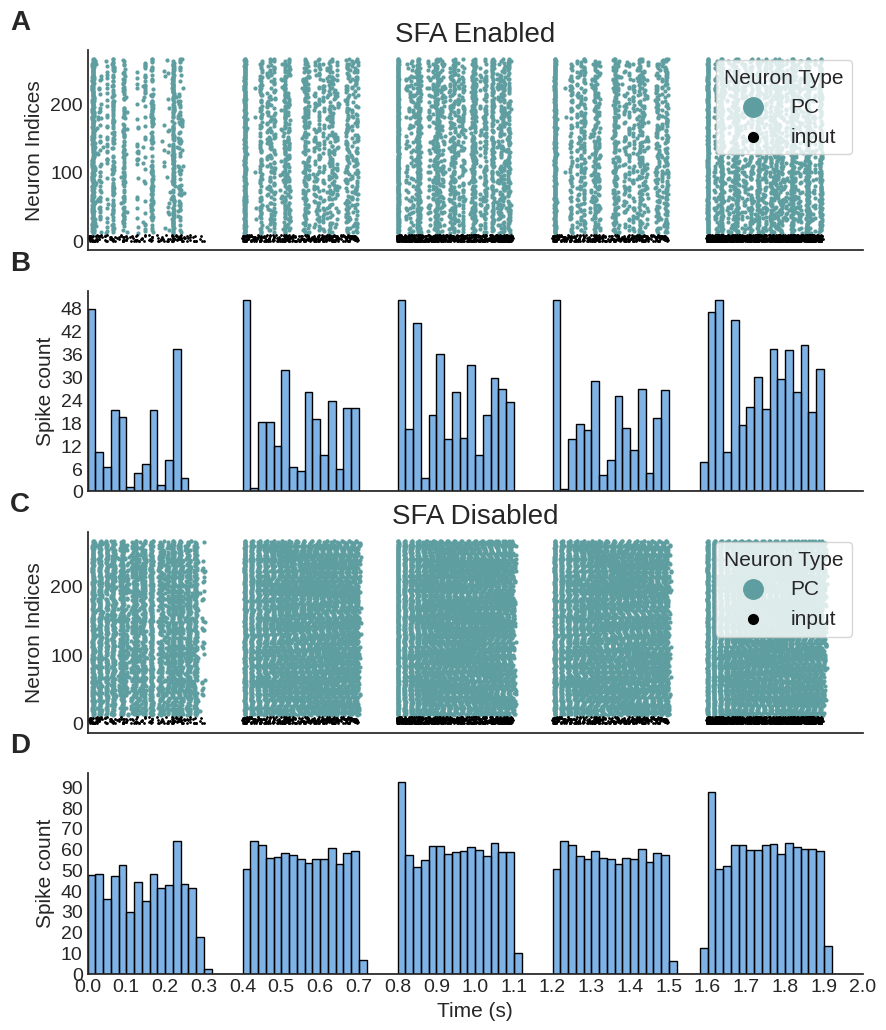

In [27]:
pattern_data_1=np.load(data_type_path+'/SFA_Pattern_ON.npy',allow_pickle=True)
pattern_data_2=np.load(data_type_path+'/SFA_Pattern_OFF.npy',allow_pickle=True)
virtual_n=10
neuron_n=255
bin_size=0.020
duration=2
fig=plot_raster_and_psth(pattern_data_1,pattern_data_2,bin_size,virtual_n,neuron_n,duration)

In [28]:

import pandas as pd

# Assuming your data arrays are structured as mentioned
data_run1 = np.load(data_type_path+'/SFA_Pattern_ON.npy',allow_pickle=True)
data_run2 = np.load(data_type_path+'/SFA_Pattern_OFF.npy',allow_pickle=True)

# Create DataFrames for each run
df_run1 = pd.DataFrame({'Run1_Index': data_run1[0], 'Run1_ID': data_run1[1]})
df_run2 = pd.DataFrame({'Run2_Index': data_run2[0], 'Run2_ID': data_run2[1]})

# Combine the DataFrames
df_combined = pd.concat([df_run1, df_run2], axis=1)

# Save to CSV
df_combined.to_csv(data_type_path+'/SFA_Pattern.csv', index=False)
